In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tikzplotlib as tikz
import pandas as pd

In [2]:
tab = pd.read_excel("table.xlsx")
tab.columns

Index(['Vegyjel', 'Z', 'Név', 'Kα [keV]', 'Kβ [keV]', 'Kβ/Kαintenzitás',
       'Lα [keV]', 'Lβ[keV]', 'Lγ [keV]'],
      dtype='object')

# 1. 

„Határozzuk meg egy keverék minta ismert elemeinek csúcsainak meghatározása után a rendszer energiakalibrációját!”

A kalibráció elvégzéséhez egy óncseppet és egy rézlemezt használjunk! Mérési idő 20s.
- Hányas számú képen szerepel a rézlemez és az óncsepp?
- Készítsen táblázatot, melyben szerepel mindkét minta mindkét vonalának csatorna-számai és irodalmi energia-értékei!

A kalibrációhoz a réz Kα és az ón Kβ vonalát használják fel!
Illesszen lineáris függvényt (  ) erre a két pontra, majd ellenőrizze, hogy a másik két (kalibrációhoz nem használt) csúcsot is kellő pontossággal ( ha az eltérés < 0.02 keV már elég jó, < 0.05 keV még elfogadható) a helyén találtuk-e!
- Adja meg az illesztés paramétereit (a, b)!
- Ábrázolja a kapott beütésszám - energia spektrumot!
A további feladatok elvégzéséhez használja fel ezt a kalibrációs egyenest!

#### A rézlemez a 6., az óncsepp a 7., képen látható

In [3]:
jel = lambda s: tab[(tab.Vegyjel == s)]
cu = jel("Cu")
sn =  jel("Sn")
cu.head()

,Vegyjel,Z,Név,Kα [keV],Kβ [keV],Kβ/Kαintenzitás,Lα [keV],Lβ[keV],Lγ [keV]
9,Cu,29,Réz,8.047,8.904,0.1423,0.928,0.948,NaN


In [4]:
sn.head()

,Vegyjel,Z,Név,Kα [keV],Kβ [keV],Kβ/Kαintenzitás,Lα [keV],Lβ[keV],Lγ [keV]
30,Sn,50,Ón,25.27,28.483,0.2202,3.444,3.662,4.131


In [5]:
def load_spectr(fname):
    with open(fname, "r") as f:
        inside = False
        dat = []
        while True:
            try:
                l = f.readlines(1)[0]
                if "<<DATA>>"in l or "<<END>>" in l:
                    inside = not inside
                
                else:
                    if inside:
                   
                        dat.append(int(l[:-1]))
                    
            except UnicodeDecodeError:
                break
        return np.array(dat)
        
kal_dat = load_spectr("kalibration.mca")

In [6]:
from scipy.signal import find_peaks
from scipy.stats import linregress
def plot_pks(dat, cali, **kwargs):
    pks = find_peaks(dat, **kwargs)[0]
    xs = np.arange(dat.shape[0])
    if not cali is None:
        xs = cali(xs)
    plt.plot(xs[pks], dat[pks], "rx")
    return pks
def plot_element(elem, scale, c):
    def plot_line(name, scale, **kwargs):
        E = float(elem[name])
        plt.plot([E, E], [0, scale],c=c, label=f"{elem.Vegyjel.values[0]}: {name[:3]}", **kwargs)
    plot_line("Kα [keV]", scale)
    plot_line("Kβ [keV]", scale*float(elem['Kβ/Kαintenzitás']), linestyle=":")
    #plot_line("Kβ [keV]", scale*float(elem['Kβ/Kαintenzitás']), linestyle=":")
def plot_spektr(dat, cali=None ,log=False, new_plot=True, name=None):
    if new_plot:
        plt.figure(figsize=(16,8))
    xs = np.arange(dat.shape[0])
    if cali is None:
        plt.xlabel("channel ID", fontsize=14)
        
    else:
        plt.xlabel(r"$E \ \mathrm{[keV]}$", fontsize=14)
        xs = cali(xs)
    plt.plot(xs, dat, label=name)
    
    plt.ylabel("count", fontsize=14)
    if log:
        plt.yscale("log")
    plt.grid()
subr = lambda dat, fro, to: (dat[fro:to], np.arange(dat.shape[0])[fro:to])
from scipy.optimize import curve_fit
gauss = lambda x, A, m, s: A*np.exp(-0.5*((x-m)/s)**2) 
def fit(da, xs, **kwargs):
    par, corr = curve_fit(gauss, xs, da, p0=[da.max(), xs.mean(), xs.std()],
                          sigma=np.sqrt(da),absolute_sigma=True)
    return par, np.sqrt(np.diag(corr))

LinregressResult(slope=0.019840776699029127, intercept=-0.008355339805824258, rvalue=1.0, pvalue=0.0, stderr=0.0)


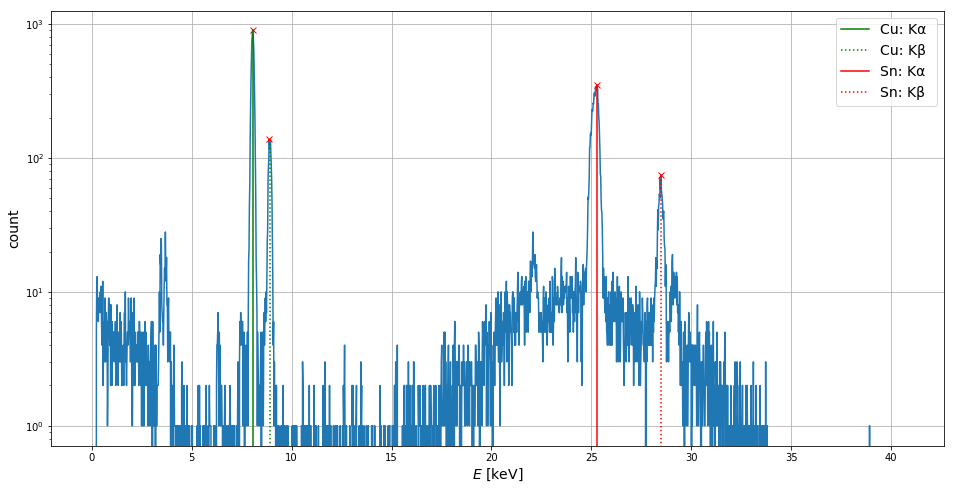

In [7]:
pks = find_peaks(kal_dat, prominence=40)[0]
chosen = np.array([float(cu["Kα [keV]"]), float(cu["Kβ [keV]"]),float(sn["Kα [keV]"]), float(sn["Kβ [keV]"])])
callin = linregress([pks[0], pks[-1]], [chosen[0], chosen[-1]])
mycal= lambda i: callin.slope*i + callin.intercept
invcal = lambda E: (E-callin.intercept)/callin.slope
print(callin)
plot_spektr(kal_dat, mycal, True)
plot_pks(kal_dat, mycal, prominence=40)
plot_element(cu, kal_dat.max(), "g")
plot_element(sn, kal_dat[kal_dat.argsort()[-10]], "r")
plt.legend(fontsize=14)

In [8]:
print(pks) # Ezek a négy K-csúcs csatornaszámai
print(mycal(pks)) # A kalibráció szerinti értékeik kV-ben
print(chosen) # Az irodalmi értékeik
print((np.array(chosen)-mycal(pks))[1:-1]) # A kalibrácihoz nem használt csúcsoknál az eltérés

[ 406  448 1274 1436]
[ 8.047       8.88031262 25.26879417 28.483     ]
[ 8.047  8.904 25.27  28.483]
[0.02368738 0.00120583]


# 2. 

„Határozzuk meg a vas Kα-vonalára a rendszer energiafelbontóképességét!„
Használja a minták között található téglalap alakú fémlemezt (a készülékhez kapott gyári kalibrációs minta)! Mérési idő 20s.
- Hányas számú képen szerepel ez a fémlemez?
Ez a fémlemez egy ötvözet, nem csak vasat tartalmaz. 
- Határozza meg a legintenzívebb csúcsokat produkáló 4 elemet (beleértve a vasat is…)! Foglalja táblázatba a megtalált elemeket, a rendszámukkal és a vonalaik mért energia-értékeivel! (Jellemzően ilyen, vagy ehhez hasonló összetételű anyagokat használnak szerszámok készítéséhez.)
- Határozza meg a készülék felbontóképességét a vas Kα vonalára!
- Ábrázolja a kapott beütésszám - energia spektrumot!

#### A gyári kalibrációs minta az 1-es ébrán szerepel

In [9]:
iron_dat = load_spectr("gy_lemez.mca")

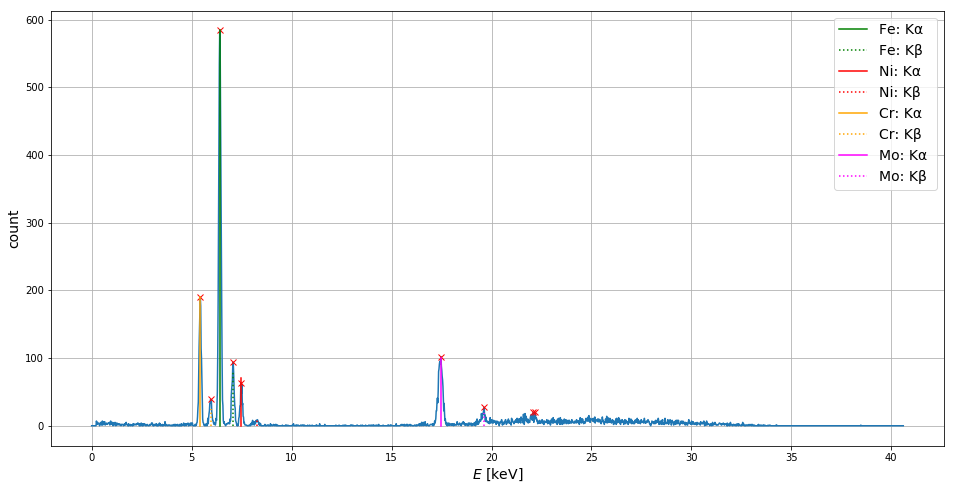

In [10]:
plot_spektr(iron_dat, mycal, False)
pks= plot_pks(iron_dat, mycal, prominence=20)
plot_element(jel("Fe"), iron_dat.max(), "g")
plot_element(jel("Ni"), 70, "r")
plot_element(jel("Cr"), 190, "orange")
plot_element(jel("Mo"), 100, [1,0,1])
plt.legend(fontsize=14)

[1.09174204e+01 8.98581207e-04 6.54581308e-04]
Fe: K_a:  E = 6.4083 keV, sigma = 0.0586 keV, resolution = 0.0091


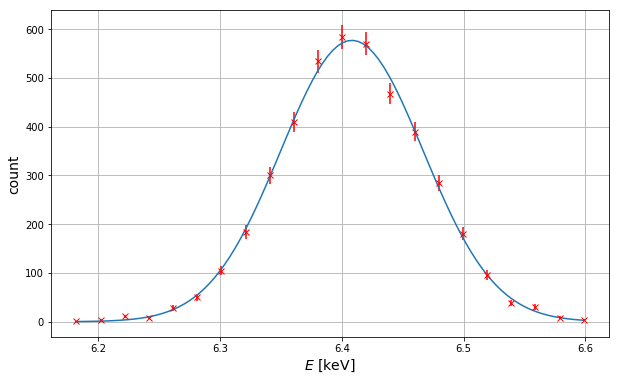

In [11]:

def work_line(dat, fro, to, name):
    da, xs = subr(dat, fro, to)
    Es = mycal(xs)
    plt.errorbar( Es, da, yerr=np.sqrt(da),fmt="rx")
    plt.xlabel(r"$E \ \mathrm{[keV]}$", fontsize=14)
    par, err = fit(da, Es)
    print(err)
    Es_ = np.linspace(Es.min(),Es.max(), 100)
    plt.plot(Es_, gauss(Es_, *par))
    plt.ylabel("count", fontsize=14)
    plt.grid()
    print(f"{name} E = {par[1]:.4f} keV, sigma = {par[2]:.4f} keV, resolution = {par[2]/par[1]:.4f}")
    return par, err
fro, to = pks[2]-11, pks[2]+11
plt.figure(figsize=(10, 6))
work_line(iron_dat, fro, to, r"Fe: K_a: ")
None

In [12]:
def do_line(dat, E, n):
        ch = int(invcal(E))
        
        da, xs = subr(dat, ch-n, ch+n)
        Es = mycal(xs)
        par, err = fit(da, Es, sigma=np.sqrt(da), maxfev=10000)
        return np.array([par[1], err[1], par[0]])
def get_Ks(elem, dat):
    nam = elem.Vegyjel.values[0]
    Z = elem.Z.values[0]
    Ka = elem["Kα [keV]"].values[0]
    Kb = elem["Kβ [keV]"].values[0]
  
    return [(Z, nam +": K_a", Ka, *do_line(dat, Ka, 11)), (Z, nam +": K_b", Kb, *do_line(dat, Kb, 11))]

compr = get_Ks(jel("Fe"), iron_dat) + get_Ks(jel("Mo"), iron_dat) + get_Ks(jel("Cr"), iron_dat) + get_Ks(jel("Ni"), iron_dat)
# vegyjel, Vonal, irodalmi frekvencia, illeszett frekvencia, Amplitúdó
compr

/home/lorenz/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:728: RuntimeWarning: divide by zero encountered in true_divide
  transform = 1.0 / sigma
/home/lorenz/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:794: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[(26,
  'Fe: K_a',
  6.403,
  6.408255245485886,
  0.0008985812073918672,
  577.0339420552177),
 (26,
  'Fe: K_b',
  7.057,
  7.0651524124574925,
  0.0024089932116172098,
  86.16037601566441),
 (42,
  'Mo: K_a',
  17.478,
  17.445290026288244,
  0.003424745423486488,
  99.65147902205379),
 (42,
  'Mo: K_b',
  19.607,
  19.588223649783984,
  0.009709141679454804,
  16.836478036526675),
 (24, 'Cr: K_a', 5.414, 5.398256310679613, inf, 190.0),
 (24, 'Cr: K_b', 5.946, 5.9339572815534005, inf, 39.0),
 (28, 'Ni: K_a', 7.477, 7.461697087378644, inf, 63.0),
 (28,
  'Ni: K_b',
  8.264,
  8.226784219025417,
  0.023116605839445227,
  4.886297155332523)]

# 3. 
„Határozzuk meg a kapott ismeretlen minták méréséből az őket alkotó főbb elemeket!”

Használja a barna, tabletta formájú, préselt mintát! Mérési idő 300s.
- Hányas számú képen szerepel a barna tabletta?

A mintában 7, egyértelműen beazonosítható elem található.
A 8. esetében a Kβ vonalát elfedi egy másik elem Kα vonala.
A 9. szintén elfedés miatt nem egyértelműen beazonosítható: segítségként el szoktam mondani, hogy mivel a mintát kézzel helyezik a készülékbe, így nyugodtan zárják ki a „nagyon mérgező” elemet és válasszák a „kevésbé mérgezőt”.
A 10. nem túl nagy intenzitású, viszont a K vonalai mellett az egyik L vonala is látható.
- Foglalja táblázatba a megtalált elemeket, a rendszámukkal és a vonalaik mért energia-értékeivel!
- Ábrázolja a kapott beütésszám - energia spektrumot!

#### A barna tabletta a 4-es képen szerepel

In [13]:
bt = load_spectr("barna tabletta.mca")

In [14]:
import matplotlib.colors as mcolors
i = 0
cl = list(mcolors.TABLEAU_COLORS.keys())*2
def plot3(elem):
    global i
    data = get_Ks(elem, bt)
    Ka_A = data[0][5]
    plot_element(elem, Ka_A, cl[i])
    i+=1
    
    return data

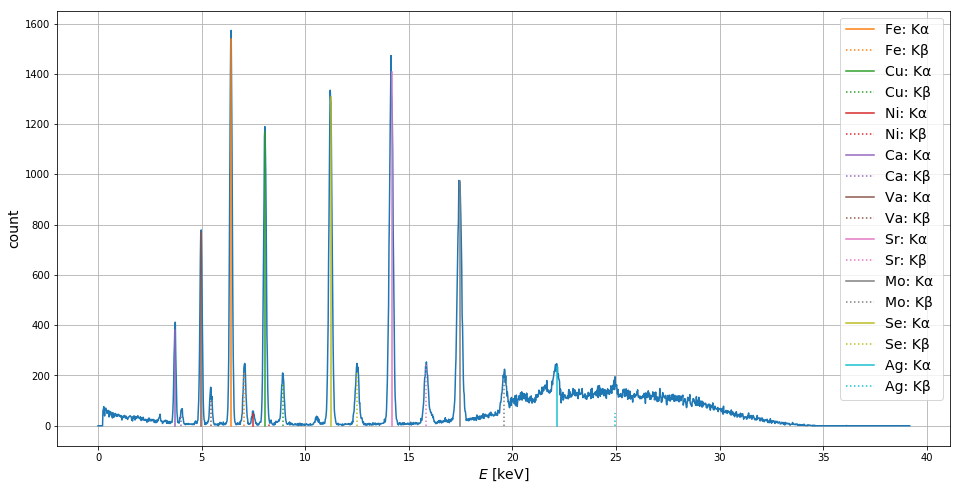

In [15]:
i = 1
plot_spektr(bt, mycal, False)
#pks= plot_pks(bt, mycal, prominence=20)
l = []
for nam in ["Fe", "Cu", "Ni", "Ca", "Va", "Sr", "Mo", "Se", "Ag"]:
    l += plot3(jel(nam))
plt.legend(fontsize=14)

In [16]:
l # az átfedéseknél néha a nagyobb koncentrációjú elem frekvenciájára konvergál a kisebb helyett

[(26,
  'Fe: K_a',
  6.403,
  6.410106607848397,
  0.0005577347600330154,
  1540.2573146460886),
 (26,
  'Fe: K_b',
  7.057,
  7.063716592940976,
  0.0015009057711763496,
  242.14784288967994),
 (29,
  'Cu: K_a',
  8.047,
  8.050719801229038,
  0.0006784224949645531,
  1169.2919241157783),
 (29,
  'Cu: K_b',
  8.904,
  8.910677749009169,
  0.0017212415787892738,
  197.90806434819729),
 (28,
  'Ni: K_a',
  7.477,
  7.481378180197638,
  0.0037096218135087597,
  48.62809068642176),
 (28,
  'Ni: K_b',
  8.264,
  8.039455278437213,
  0.003230776487813964,
  1197.2790247388784),
 (20,
  'Ca: K_a',
  3.691,
  3.7050380319072977,
  0.0010486280298711117,
  379.15110975504587),
 (20,
  'Ca: K_b',
  4.012,
  4.018732120739607,
  0.0033390217454740087,
  55.77562060446443),
 (23,
  'Va: K_a',
  4.952,
  4.963804361998894,
  0.0007573709830664875,
  769.0857865560355),
 (23,
  'Va: K_b',
  5.427,
  5.438400507193513,
  0.001878905394050078,
  141.97497586749685),
 (38,
  'Sr: K_a',
  14.164,
  14.

#### 4. 

„Határozzuk meg a Moseley-törvény konstansait a mért csúcsok energiáinak ismeretében!”
Itt használja az előző feladatban szereplő barna tablettát! Újabb mérésre nincs szükség, az előző adatsor használható.
Adja meg a kiszámolt konstansok értékeit!

In [17]:
lins = np.array(l)
lins

array([['26', 'Fe: K_a', '6.403', '6.410106607848397',
        '0.0005577347600330154', '1540.2573146460886'],
       ['26', 'Fe: K_b', '7.057', '7.063716592940976',
        '0.0015009057711763496', '242.14784288967994'],
       ['29', 'Cu: K_a', '8.047', '8.050719801229038',
        '0.0006784224949645531', '1169.2919241157783'],
       ['29', 'Cu: K_b', '8.904', '8.910677749009169',
        '0.0017212415787892738', '197.90806434819729'],
       ['28', 'Ni: K_a', '7.477', '7.481378180197638',
        '0.0037096218135087597', '48.62809068642176'],
       ['28', 'Ni: K_b', '8.264', '8.039455278437213',
        '0.003230776487813964', '1197.2790247388784'],
       ['20', 'Ca: K_a', '3.691', '3.7050380319072977',
        '0.0010486280298711117', '379.15110975504587'],
       ['20', 'Ca: K_b', '4.012', '4.018732120739607',
        '0.0033390217454740087', '55.77562060446443'],
       ['23', 'Va: K_a', '4.952', '4.963804361998894',
        '0.0007573709830664875', '769.0857865560355'],
    

[0.01051069 1.30450639]
[0.01221101 1.98085258]


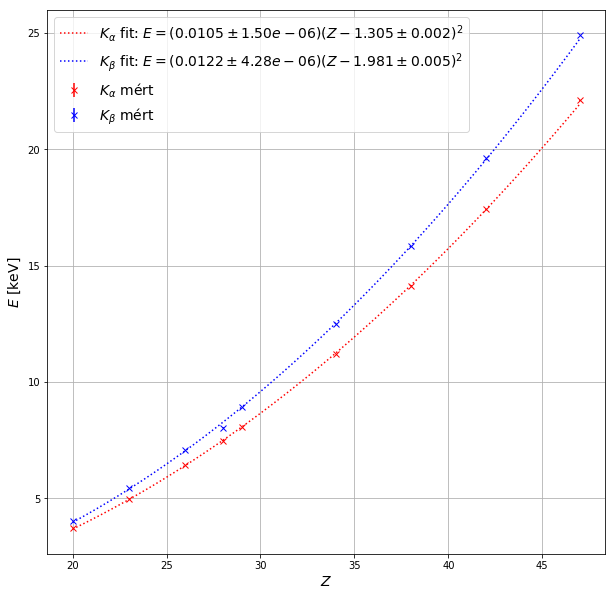

In [18]:
M_func = lambda Z, A, B: A*(Z - B)**2
Zs = lins[::2,0].astype(int)
Kas = lins[::2,3].astype(float)
dKas = lins[::2,4].astype(float)
Kbs = lins[1::2,3].astype(float)
dKbs = lins[1::2,4].astype(float)
plt.figure(figsize=(10, 10))
def fit_Moseley(Zs, Ks,dKs, color, name):
    
    plt.errorbar(Zs, Ks,yerr=dKs, fmt=f"{color}x", label=f"${name}$ mért")
    par, corr = curve_fit(M_func, Zs, Ks, sigma=dKs, absolute_sigma=True)
    err = np.sqrt(np.diag(corr))
    Zs_ = np.linspace(Zs.min(), Zs.max(), 100)
    plt.plot(Zs_, M_func(Zs_, *par), f"{color}:", 
    label=f"${name}$ fit: $E=({par[0]:.4f}\pm{err[0]:.2e})(Z - {par[1]:.3f}\pm{err[1]:.3f})^2$")
    print(par)
fit_Moseley(Zs, Kas,dKas, "r", r"K_\alpha")
fit_Moseley(Zs, Kbs,dKbs, "b", r"K_\beta")
plt.xlabel("$Z$", fontsize=14)
plt.ylabel(r"$E \ \mathrm{[keV]}$", fontsize=14)
plt.legend(fontsize=14)
plt.grid()

# 5. 

„Határozzuk meg egy falevél ólomtartalmát külső standardizálással!”

A feladat annyiban módosul, hogy nem a jegyzetben leírt módon, ismert mennyiségű ólom hozzáadásával kell elvégezni ezt, hanem adott két, egyéb paramétereben azonos minta, amik közül az egyik jelentősebb mértékű ólmot tartalmaz. Az egyik egy „t”-vel jelzett tiszta minta, a másik egy „p”-vel jelzett piszkos minta. 

Mindkettő, a további szennyeződések elkerülése végett, kis műanyag tasakba van zárva. A tasakból nem szabad kivenni a mintákat! A tiszta minta mérési ideje 300s, a piszkosé 60s.
- Hányas számú képen szerepel a tiszta és a piszkos minta?
- Ábrázolja a kapott beütésszám - energia spektrumokat közös ábrán!

Mivel egyik minta esetében sem ismerjük a pontos mennyiséget, így csak azt lehetséges kiszámolni, hogy a piszkos mintában hányszor annyi ólom van, mint a tisztában. A görbe alatti területek és a mérési idő ismeretében ez az arányszám könnyen kiszámolható.
- Hányszoros az ólomkoncentráció a piszkos mintában a tisztához képest?

In [19]:
tiszta = load_spectr("tiszta.mca")
piszkos = load_spectr("piszkos.mca")

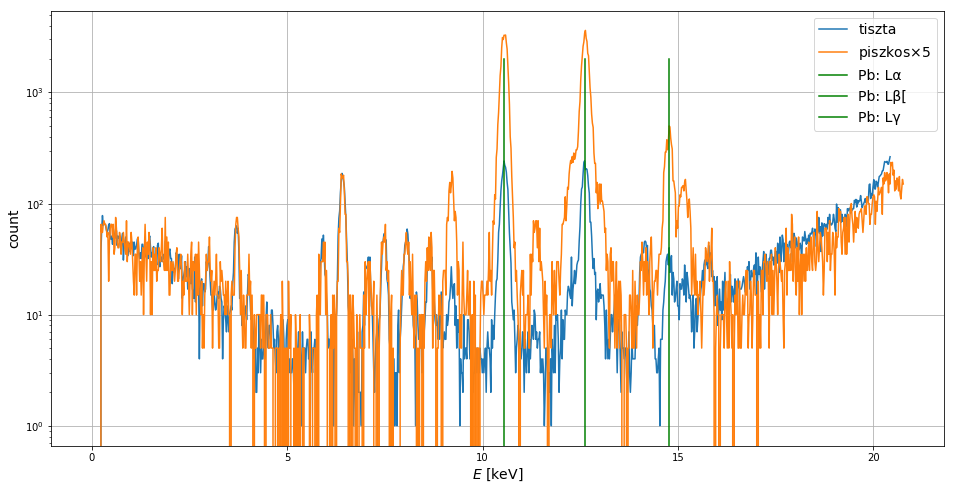

In [20]:
def plot_Ls(elem, scale, c):
    def plot_line(name, scale, **kwargs):
        E = float(elem[name])
        plt.plot([E, E], [0, scale],c=c, label=f"{elem.Vegyjel.values[0]}: {name[:3]}", **kwargs)
    plot_line("Lα [keV]", scale)
    plot_line("Lβ[keV]", scale)
    plot_line("Lγ [keV]", scale)
plot_spektr(tiszta[:-1000], mycal, True, True, name="tiszta")
plot_spektr(piszkos[:-1000]*5, mycal, True, False, name=r"piszkos$\times5$")
plot_Ls(jel("Pb"), 2000, 'g')
plt.legend(fontsize=14)
plt.grid()

[5.75145709e+00 1.76969061e-03 1.39741044e-03]
Pb: L_a:  E = 10.5531 keV, sigma = 0.0852 keV, resolution = 0.0081
[2.26730224e+01 4.42677425e-04 3.37557190e-04]
Pb: L_a:  E = 10.5511 keV, sigma = 0.0813 keV, resolution = 0.0077


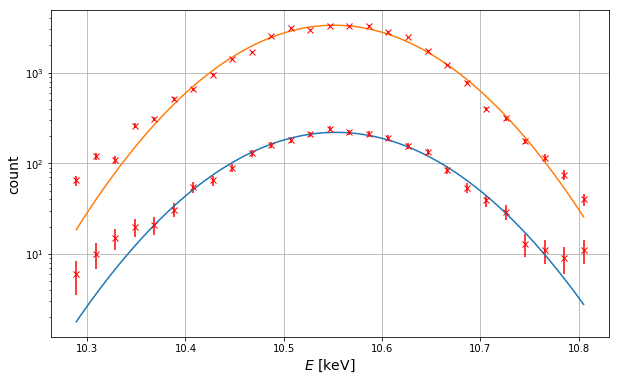

In [21]:
ID = int(invcal(10.55))
fro, to = ID-13, ID+14
plt.figure(figsize=(10, 6))
tisz_p, tisz_e = work_line(tiszta, fro, to, r"Pb: L_a: ")
pisz_p, pisz_e = work_line(piszkos*5, fro, to, r"Pb: L_a: ")
plt.yscale("log")
plt.grid()

In [22]:
Ter = lambda p : p[0]*p[1]*np.sqrt(2*np.pi)
ratio = Ter(pisz_p)/Ter(tisz_p)
dTer = lambda p, e: e[0]/p[0] + e[1]/p[1]
error = ratio*(dTer(pisz_p, pisz_e) + dTer(tisz_p, tisz_e))
ratio, error

(15.192321317906712, 0.5031389222087878)

# 6. 

„Bizmut-, ólom- és wolfram-minták mérésével határozzuk meg a Moseley-törvény
konstansait L-vonalakra! 

- Értelmezzük az ¨ A és B konstansok jelentését!”

Ólom mintát nem szükséges újra mérni, felhasználható az előző feladat piszkos mintája erre a célra. A bizmut egy érdekes alakú kristály, a wolfram egy szürkés fém, ami itt kis hasábokban található.
- Hányas számú képen szerepel a bizmut- és a wolfram-minta? 
- Foglalja táblázatba az ólom, a bizmut és a wolfram spektrum-csúcsainak mért energia-értékeit (ha a mérés korábbi feladatai során talált egyéb L-vonalhoz tartozó csúcsot, azt is)! 
- Adja meg a kiszámolt konstansok értékeit!

A bizmut és a wolfram a 8. képen szerepelnek

In [23]:
bism = load_spectr("bizmut.mca")
tung = load_spectr("wolfram.mca")

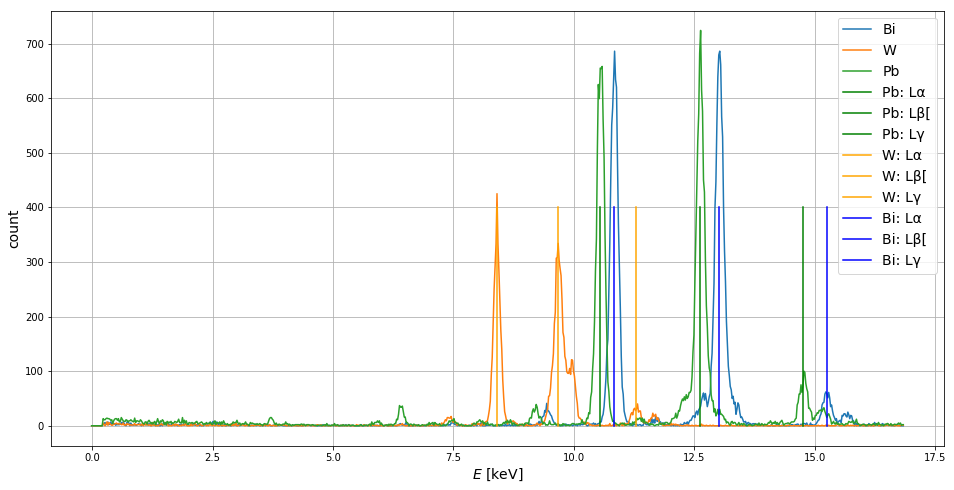

In [24]:
K = 850
plot_spektr(bism[:K], mycal, False, True, "Bi")
plot_spektr(tung[:K], mycal, False, False, "W")
plot_spektr(piszkos[:K], mycal, False, False, "Pb")
plot_Ls(jel("Pb"), 400, 'g')
plot_Ls(jel("W"), 400, 'orange')
plot_Ls(jel("Bi"), 400, 'b')
plt.legend(fontsize=14)

In [58]:
def get_Ls(dat, prom):
    peaks = find_peaks(dat, prominence=prom)[0]
    Es = mycal(peaks)
    print(Es)
    Es_ = np.stack([do_line(dat, E, 10)[:2] for E in Es])
    return Es_
    
E_Ls = np.stack([get_Ls(tung[:K], 30),
        get_Ls(piszkos[:K], 50),
        get_Ls(bism[:K], 50)])
E_Ls.shape, E_Ls[:,:,0]

[ 8.40413398  9.67394369 11.32072816]
[10.58661942 12.63021942 14.7730233 ]
[10.84454951 13.02703495 15.22936117]


((3, 3, 2), array([[ 8.403421  ,  9.68713783, 11.2960193 ],
        [10.55261272, 12.6277248 , 14.76958452],
        [10.83784069, 13.02461202, 15.25096029]]))

In [54]:
Zs = np.array([ jel("W").Z.values[0],jel("Pb").Z.values[0], jel("Bi").Z.values[0]])
Zs

array([74, 82, 83])

[1.90923348e-03 7.65624946e+00]
[3.04325016e-03 1.75816118e+01]
[3.64695808e-03 1.83498684e+01]


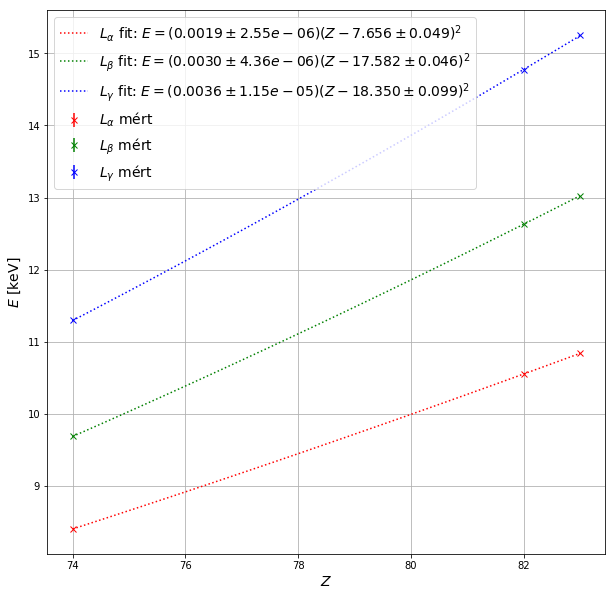

In [62]:
plt.figure(figsize=(10, 10))
fit_Moseley(Zs, E_Ls[:,0,0], E_Ls[:,0,1], "r", r"L_\alpha")
fit_Moseley(Zs, E_Ls[:,1,0], E_Ls[:,1,1], "g", r"L_\beta")
fit_Moseley(Zs, E_Ls[:,2,0], E_Ls[:,2,1], "b", r"L_\gamma")
plt.xlabel("$Z$", fontsize=14)
plt.ylabel(r"$E \ \mathrm{[keV]}$", fontsize=14)
plt.legend(fontsize=14)
plt.grid()